В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [3]:
#pip install xgboost

In [4]:
#!conda install -c conda-forge xgboost

In [5]:
#pip install hyperopt

In [6]:
#conda install -c conda-forge xgboost hyperopt

In [7]:
#pip install lightgbm

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from typing import Tuple, Dict, Any

from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import lightgbm as lgb

import time

In [9]:

def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [10]:
def compute_auroc_and_build_roc(train_targets, train_probs, val_targets, val_probs, name=''):
  
  # Compute ROC curve
  fpr_train, tpr_train, trashold = roc_curve(train_targets, train_probs, pos_label=1.0)
  fpr_val, tpr_val, trashold = roc_curve(val_targets, val_probs, pos_label=1.0)

  # Compute AUROC
  roc_auc_train = auc(fpr_train, tpr_train)
  roc_auc_val = auc(fpr_val, tpr_val)
  print(f'AUROC for Train: {roc_auc_train:.2f}')
  print(f'AUROC for Val: {roc_auc_val:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve Train (area = {roc_auc_train:.2f})')
  plt.plot(fpr_val, tpr_val, color='Blue', lw=2, label=f'ROC curve Val (area = {roc_auc_val:.2f})')

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name} model')
  plt.legend(loc="lower right")
  plt.show()

  return roc_auc_train, roc_auc_val


In [11]:
main_df = pd.read_csv('./bank-customer-churn-prediction-dlu/train.csv', index_col=0)

#Визначаємо таргет
target_col = 'Exited'
#Видаляємо не впливові колонки, які знаємо з попередніх експерементів
columns_to_drop = ['Exited','CustomerId', 'Surname']
#Визначаємо основні колонки 
input_col = main_df.columns.drop(columns_to_drop).to_list()

category_features = main_df[input_col].select_dtypes(include=['object']).columns.tolist()
numeric_features = main_df[input_col].select_dtypes(include=['int64', 'float64']).columns.tolist()

train_df, val_df = split_train_val(main_df, target_col, test_size=0.2, random_state=42)

train_inputs, train_targets = separate_inputs_targets(train_df, input_col, target_col)
val_inputs, val_targets = separate_inputs_targets(val_df, input_col, target_col)

1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [12]:
train_inputs[category_features] = train_inputs[category_features].astype('category')
val_inputs[category_features] = val_inputs[category_features].astype('category')

In [13]:
train_inputs.dtypes

CreditScore         float64
Geography          category
Gender             category
Age                 float64
Tenure              float64
Balance             float64
NumOfProducts       float64
HasCrCard           float64
IsActiveMember      float64
EstimatedSalary     float64
dtype: object

In [14]:
train_inputs.shape

(12000, 10)

In [15]:
train_inputs.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

Час роботи моделі: 0.07840394973754883
AUROC for Train: 0.95
AUROC for Val: 0.93


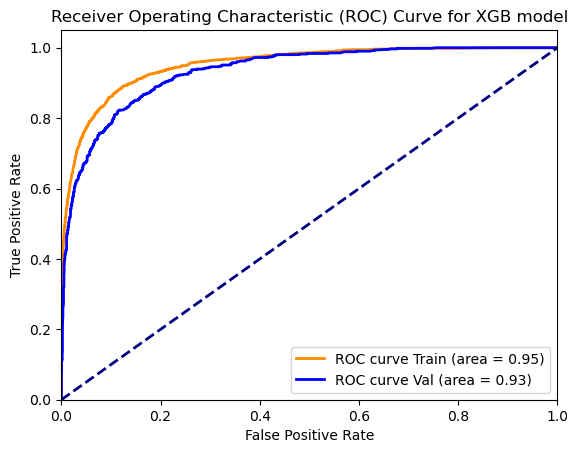

In [26]:
xgb_model = XGBClassifier(
    max_depth=6,
    n_estimators=10,
    enable_categorical=True,
    device = 'cuda'  #tree_method='hist', #
)

start_time = time.time()
xgb_model.fit(train_inputs, train_targets) 
end_time = time.time()
search_time = end_time - start_time

print("Час роботи моделі:", search_time)

train_pred_xgb = xgb_model.predict_proba(train_inputs)[:, 1]
val_pred_xgb = xgb_model.predict_proba(val_inputs)[:, 1]

train_roc_auc_xgb, val_roc_auc_xgb= compute_auroc_and_build_roc(
    train_targets, train_pred_xgb, val_targets, val_pred_xgb, 'XGB'
    )


По результатам бачимо, що модель дуже чудово справилась з обчисленнями та показала високі результати.
Модель не має high bias/high variance

In [22]:
# Порівняння з попередніми результатами
train_roc_auc_decision_tree = 0.94
val_roc_auc_decision_tree = 0.92

# Порівняння моделей на тренувальних даних
print("Порівняння моделей на тренувальних даних:")
print(f"Decision Tree Train ROC AUC: {train_roc_auc_decision_tree:.2f}")
print(f"Попередній kNN Train ROC AUC: {train_roc_auc_xgb:.2f}")

# Порівняння моделей на валідаційних даних
print("\nПорівняння моделей на валідаційних даних:")
print(f"Decision Tree Validation ROC AUC: {val_roc_auc_decision_tree:.2f}")
print(f"Попередній kNN Validation ROC AUC: {val_roc_auc_xgb:.2f}")


Порівняння моделей на тренувальних даних:
Decision Tree Train ROC AUC: 0.94
Попередній kNN Train ROC AUC: 0.95

Порівняння моделей на валідаційних даних:
Decision Tree Validation ROC AUC: 0.92
Попередній kNN Validation ROC AUC: 0.93


Порівняння показує, що XGBoost з масштабуванням фічей показує трохи кращі результати, ніж DecisionTree. Це свідчить про те, що модель XGBoost є кращою для цього завдання.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

100%|██████████| 20/20 [00:07<00:00,  2.52trial/s, best loss: -0.9362288222786199]
Найкращі гіперпараметри:  {'colsample_bytree': 0.7915147631771378, 'gamma': 0.3702802242803974, 'learning_rate': 0.10258257883460706, 'max_depth': 4, 'min_child_weight': 9, 'n_estimators': 50, 'reg_alpha': 0.4183355703220143, 'reg_lambda': 0.022223117447533247, 'subsample': 0.8799219929600561}
AUROC for Train: 0.94
AUROC for Val: 0.94


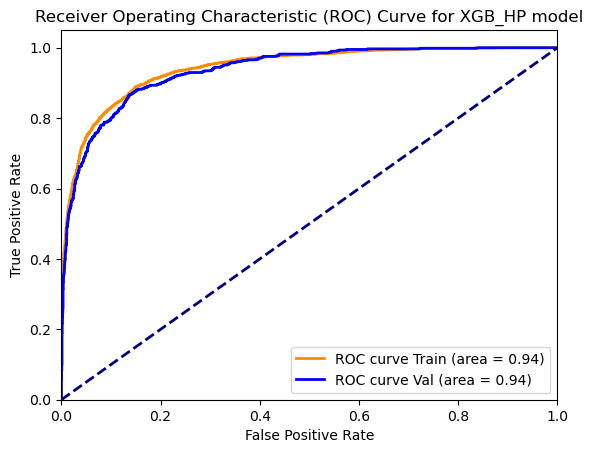

In [25]:
def objective(params):
    xgb_clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        gamma=params['gamma'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        enable_categorical=True,
        device='cuda'
    )

    xgb_clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False)
    
    pred = xgb_clf.predict_proba(val_inputs)[:,1]
    val_roc_auc = roc_auc_score(val_targets, pred)

    return {'loss': -val_roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=20, 
            trials=trials
            )

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    device='cuda',
    eval_metric='auc'
)

final_clf.fit(train_inputs, train_targets)

train_final_pred = final_clf.predict_proba(train_inputs)[:,1]
val_final_pred = final_clf.predict_proba(val_inputs)[:,1]

train_roc_auc_xgb_hp, val_roc_auc_xgb_hp= compute_auroc_and_build_roc(
    train_targets, train_final_pred, val_targets, val_final_pred, 'XGB_HP'
    )

Оцінка моделі майже зрівнялась між тренувальними та валідаційними даними і досягла найкращого результату на валідаційних даних.
Модель є стабільною, без high variance і є хорошою для вирішення цієї задачі.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [27]:
print(lgb.__version__)

4.5.0


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] Unknown parameter: missing
AUROC for Train: 0.96
AUROC for Val: 0.93


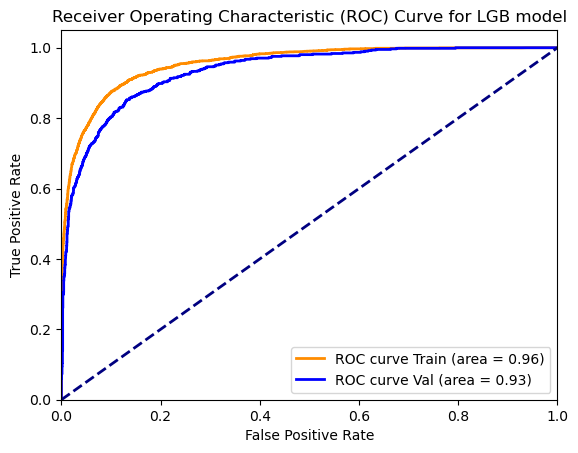

In [28]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in category_features]

lgb_clf = lgb.LGBMClassifier(
    max_depth=6,
    n_estimators=50,
    learning_rate=0.1,
    cat_feature=cat_feature_indexes,  # для автоматичного розпізнавання категорійних ознак
    missing=np.nan,  # явне вказування пропущених значень
)

lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])

train_pred_lgb = lgb_clf.predict_proba(train_inputs)[:,1]
val_pred_lgb = lgb_clf.predict_proba(val_inputs)[:,1]

train_roc_auc_lgb, val_roc_auc_lgb= compute_auroc_and_build_roc(
    train_targets, train_pred_lgb, val_targets, val_pred_lgb, 'LGB'
    )


Модель демонструє чудові значення схожі з попередньою моделю, спробцємо підібрати найкращі параметри 

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 843                      
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561 
Training until validation scores don't improve for 10 rounds
Early st

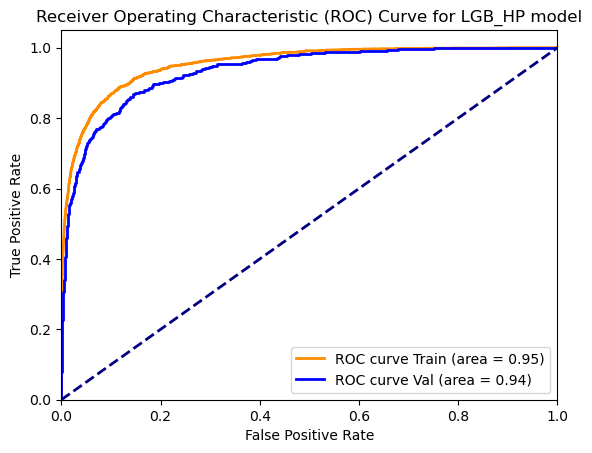

In [29]:
def objective(params):
    lgb_hp = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes,  # Індекси категорійних ознак
        early_stopping_rounds=10
    )

    lgb_hp.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
    pred = lgb_hp.predict_proba(val_inputs)[:,1]
    val_roc_auc = roc_auc_score(val_targets, pred)

    return {'loss': -val_roc_auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=10, 
            trials=trials
            )

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_hp = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    random_state=42
)

final_lgb_hp.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)])
train_final_pred = final_lgb_hp.predict_proba(train_inputs)[:,1]
val_final_pred = final_lgb_hp.predict_proba(val_inputs)[:,1]

train_roc_auc_lgb_hp, val_roc_auc_lgb_hp= compute_auroc_and_build_roc(
    train_targets, train_final_pred, val_targets, val_final_pred, 'LGB_HP'
    )


Порівнявши з попередньою моделю xgb з найкращими параметрами, бачимо що на тренувальних даних вона краще навчилась, а на валідаційних показує туж оцінку,  що все ж лишається найкращим результатом на валідаційних даних.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

Для змагання обрала б дві моделі xgb / lgb з підібраними параметрами, 
щоб побачити яка краще спрацює на тестових даних.